In [ ]:
# ------------------------------------------
# Was tut dieses Skript?
# Dieses Skript verarbeitet Mapillary-Coverage-Daten für Deutschland,
# filtert sie nach Zeit und Pano-Status, erstellt Geometriepuffer und speichert die Ergebnisse als Parquet-Dateien.
# ------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from datetime import datetime, timezone


from config import GEOFABRIK_CONFIG, PROCESSING_CONFIG, MAPILLARY_CONFIG, TILES_CONFIG

In [2]:
# Input: (Parquet File) mapillary coverage lines per tile 

# Output: Buffered lines per tile for pano only and all

In [3]:
import glob

parquet_files = glob.glob( PROCESSING_CONFIG["ml_output_folder"]+ "/mapillary_coverage_DE-*.parquet")
mapillary_coverage = gpd.GeoDataFrame(pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True))

mapillary_coverage

,geometry,captured_at,creator_id,id,image_id,is_pano,tile_x,tile_y,organization_id
0,"MULTILINESTRING ((9.90967 50.71841, 9.91036 50...",2023-11-03,102976398952710,QIvRdog51kLwKStODMl96u,284583047888519,False,8643,5505,NaN
1,"LINESTRING (9.91667 50.71961, 9.9167 50.71961,...",2023-11-03,102976398952710,pnNwBZA0fUek1oiIGu69qD,842321264269748,False,8643,5505,NaN
2,"LINESTRING (9.93164 51.37102, 9.9318 51.37113,...",2023-08-25,109752671252812,YoOiu5zpJf69IrEWAlxVLH,829140848607036,False,8644,5458,NaN
3,"LINESTRING (9.95053 51.35843, 9.95052 51.35839)",2025-05-13,102468835332129,Nm3PTGjFCIs49bf1pEH7wL,1769557033774522,False,8644,5458,NaN
4,"LINESTRING (9.93164 51.371, 9.93206 51.37127, ...",2023-08-25,109752671252812,qVZ3bXcCs5hPMLyO28J9ed,834800741697508,False,8644,5458,NaN
...,...,...,...,...,...,...,...,...,...
903783,"LINESTRING (11.27197 54.41679, 11.27223 54.416...",2025-06-20,102923368613804,YonUfQTgW0XFaCrZSDKy6w,1945022226314852,False,8705,5228,NaN
903784,"LINESTRING (11.27252 54.41665, 11.27267 54.416...",2025-06-20,102923368613804,W4D09N7mFqjc56tAS2yzvh,534028509794768,False,8705,5228,NaN
903785,"LINESTRING (11.29394 54.41217, 11.29362 54.412...",2025-06-20,102923368613804,kCmviT24e9ybVKD0uzqhpO,1416873349588918,False,8705,5228,NaN
903786,"LINESTRING (11.29395 54.41219, 11.29584 54.412...",2025-06-20,102923368613804,W4D09N7mFqjc56tAS2yzvh,534028509794768,False,8706,5228,NaN


In [ ]:
## just check data with plots

Text(0.5, 1.0, 'Germany - later than 2023-01-01: Both Pano and Non-Pano')

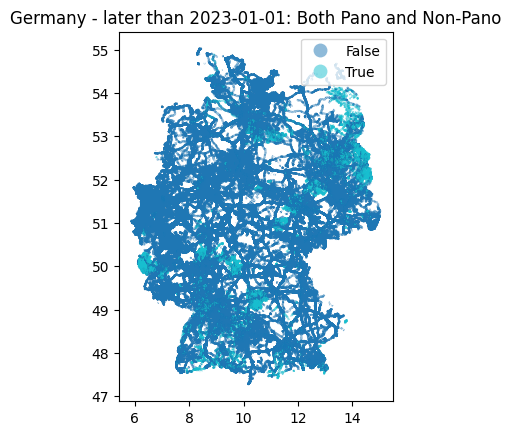

In [4]:
ax = mapillary_coverage.plot(column="is_pano", alpha=0.5, legend=True)
#plt.title("No Time Filter: Both Pano and Non-Pano")
plt.title("Germany - later than 2023-01-01: Both Pano and Non-Pano")

Text(0.5, 1.0, 'Berlin - later than 2023-01-01: Both Pano and Non-Pano')

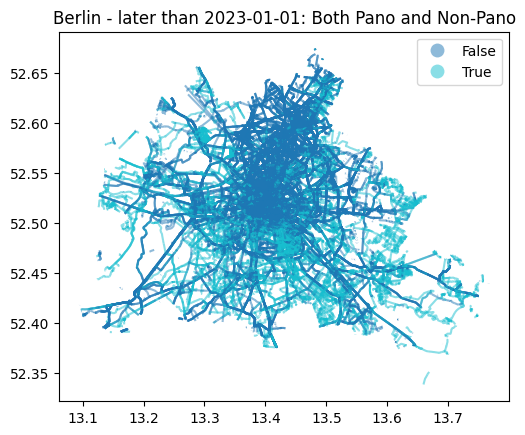

In [ ]:
bland = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json")
bland=bland[bland["id"].isin(["DE-BE"])]


mapillary_coverage_clipped = mapillary_coverage.clip(bland)

ax = mapillary_coverage_clipped.plot(column="is_pano", alpha=0.5, legend=True)
#plt.title("No Time Filter: Both Pano and Non-Pano")
plt.title("Berlin - later than 2023-01-01: Both Pano and Non-Pano")

In [ ]:

# Convert 'captured_at' to datetime
mapillary_coverage_clipped['captured_at'] = pd.to_datetime(mapillary_coverage_clipped['captured_at'])

# Create a naive Timestamp with the desired date (no timezone information)
filter_date = pd.Timestamp(datetime(2025, 1, 1))

# Filter rows where 'captured_at' is after January 1, 2023
filtered_mapillary_coverage = mapillary_coverage_clipped[
    mapillary_coverage_clipped['captured_at'] >= filter_date
]

Text(0.5, 1.0, 'later than 2025-01-01: Both Pano and Non-Pano')

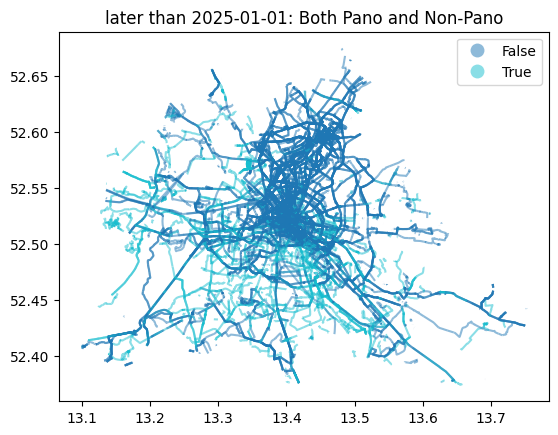

In [ ]:
ax = filtered_mapillary_coverage.plot(column="is_pano", alpha=0.5, legend=True)
plt.title("later than 2025-01-01: Both Pano and Non-Pano")

In [ ]:

# berlin both pano and non-pano ~ 1min
## Germany: both pano and non-pano ~ 25min

## 25-05-12:
## Germany: both pano and non-pano ~ 11min

## 25-10-07:
## Germany: both pano and non-pano ~ 8min



# explode the geometry to make buffering faster
mapillary_coverage_exploded = mapillary_coverage.explode(index_parts=False, ignore_index=True)

# create 10m buffers for all the lines
mapillary_coverage_buffered = mapillary_coverage_exploded.to_crs(25832).copy()
mapillary_coverage_buffered['geometry'] = mapillary_coverage_buffered['geometry'].buffer(10)


mapillary_coverage_dissolved = mapillary_coverage_buffered.dissolve(by=['tile_x', 'tile_y','is_pano'])
mapillary_coverage_dissolved = mapillary_coverage_dissolved.reset_index()





In [ ]:
# keep only necessary columns
mapillary_coverage_dissolved_cleaned = mapillary_coverage_dissolved[['tile_x', 'tile_y', 'is_pano', 'geometry']].copy()


# write dissolved buffered file
#mapillary_coverage_dissolved_cleaned.to_parquet("ml_output/mapillary_coverage_germany_buffered10m_dissolved_23-01-01_until_25-10-07.parquet")
mapillary_coverage_dissolved_cleaned.to_parquet( PROCESSING_CONFIG["ml_output_folder"]+  "/mapillary_coverage_germany_buffered_latest.parquet")


In [ ]:
#mapillary_coverage_dissolved_cleaned[mapillary_coverage_dissolved_cleaned.is_pano==True][:1].plot()